# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
altgraph                     0.17.2
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
blinker                      1.9.0
cachetools                   5.5.0
certifi                      2024.8.30
charset-normalizer           3.3.2
click                        8.1.7
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.5
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.1.0
Flask                        3.0.3
flatbuffers                  24.3.25
fonttools                    4.53.1
future                       0.18.2
gast                         0.6.0
google-auth                  2.35.0
google-auth-oauthlib         1.2.1
google-pasta                 0.2.0
grpcio                       1.66.1


In [4]:
import tensorflow as tf
import os

/Users/remiore/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove images with wrong formats, blurry, invalid, corrupted or mislabeled

In [7]:
import cv2 #Part of OpenCV, it provides functions to read, process, and manipulate images. In this context, cv2.imread() reads an image from a file.
import imghdr #Python module that identifies the type of an image file by checking its header.

In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png'] #a list of acceptable formats

In [10]:
# iterates through images in a dataset directory, checks if each image has a valid extension, and removes any invalid or corrupted images.
for image_class in os.listdir(data_dir): #iterates through each class folder in data_dir.
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image) #Constructs the full path to each image.
        try: #Attempts to read the image.
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: #Checks the image format & If the format isn't in image_exts, the image is removed.
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Loading Datasets

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
#create an image dataset directly from a directory of images, where each subdirectory represents a class.
#TensorFlow will scan the 'data' directory, assign labels based on folder names, and create a dataset suitable for training and validation.
data = tf.keras.utils.image_dataset_from_directory('data') 

Found 304 files belonging to 2 classes.


In [13]:
#converts the data dataset into an iterator that yields batches as NumPy arrays. 
#This is useful when you want to access the raw images and labels in the dataset in NumPy format, 
#which can make it easier to preview the data or manipulate it outside of the TensorFlow pipeline.
data_iterator = data.as_numpy_iterator()

In [14]:
#to access a single batch, Each batch will contain two arrays: one for images and one for labels.
batch = data_iterator.next()

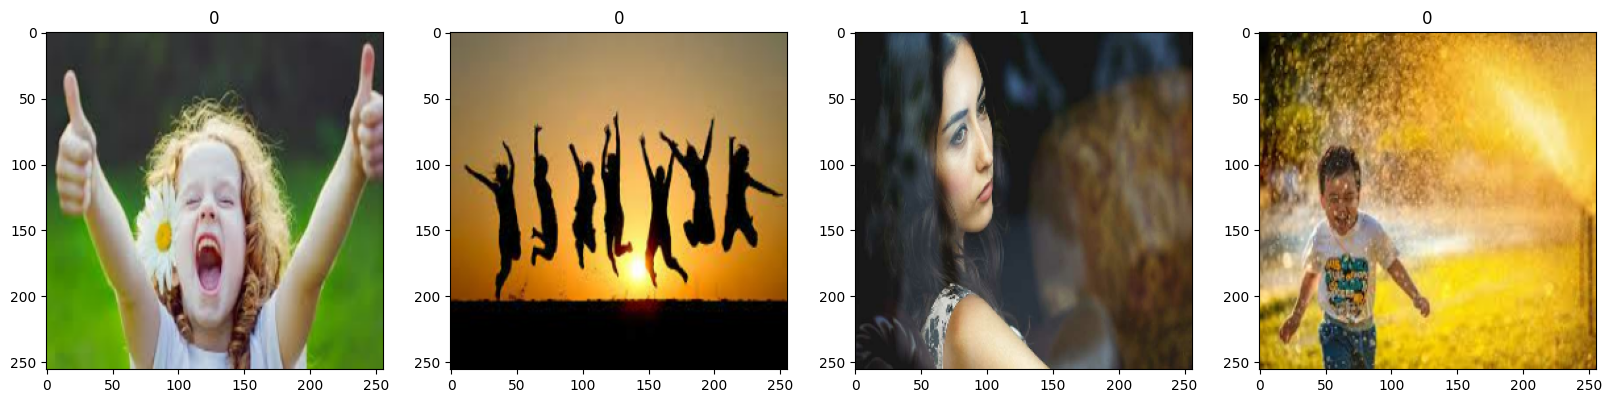

In [15]:
#generates a 2x2 grid of images, displaying the first four images from a batch.
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #Sets up a figure with 4 columns to display four images side by side, each with a large size for clarity.
for idx, img in enumerate(batch[0][:4]): #Iterates over the first four images in the batch.
    ax[idx].imshow(img.astype(int)) #Displays each image in its respective subplot, converting pixel values to integers.
    ax[idx].title.set_text(batch[1][idx])

# 4. Scaling my Datasets

In [16]:
#I am trying to normalize the pixel values of images to a range between 0 and 1 to help improve model performance and stability
#standardized values help prevent issues like exploding or vanishing gradients, making it easier for the model to learn meaningful patterns
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next() #retrieves the next batch of data from the data dataset in the form of NumPy array containing the images and the corresponding labels

(array([[[[0.99215686, 0.9137255 , 0.9098039 ],
          [0.99114585, 0.9127145 , 0.9087929 ],
          [0.9882353 , 0.9098039 , 0.90588236],
          ...,
          [0.972549  , 0.9137255 , 0.9019608 ],
          [0.972549  , 0.91663605, 0.90487134],
          [0.9761336 , 0.9212316 , 0.9094669 ]],
 
         [[0.99215686, 0.9137255 , 0.9098039 ],
          [0.99114585, 0.9127145 , 0.9087929 ],
          [0.9882353 , 0.9098039 , 0.90588236],
          ...,
          [0.972549  , 0.9137255 , 0.9019608 ],
          [0.972549  , 0.91663605, 0.90487134],
          [0.9761336 , 0.9212316 , 0.9094669 ]],
 
         [[0.9916054 , 0.91317403, 0.90925246],
          [0.99073654, 0.9123052 , 0.9083836 ],
          [0.9882353 , 0.9098039 , 0.90588236],
          ...,
          [0.972549  , 0.9137255 , 0.9019608 ],
          [0.972549  , 0.91663605, 0.90487134],
          [0.9761336 , 0.9212316 , 0.9094669 ]],
 
         ...,
 
         [[0.972549  , 0.9137255 , 0.9019608 ],
          [0.97254

# 5. Splitting the Data

In [18]:
#splits my dataset into training, validation, and test sets
train_size = int(len(data)*.7) #70% of the total data to be used for training
val_size = int(len(data)*.2) #20% for validation
test_size = int(len(data)*.1) #10% for testing

In [19]:
train_size

7

In [20]:
train = data.take(train_size) #select the first train_size elements from data to create the training dataset.
val = data.skip(train_size).take(val_size)#skips the first train_size elements and then takes the next val_size elements for the validation dataset.
test = data.skip(train_size+val_size).take(test_size)#skips the elements used for both the training and validation datasets, then takes the next test_size elements for the test datase

# 6. Building my Deep Learning Model

In [21]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Training my model

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 5s 488ms/step - loss: 0.8131 - accuracy: 0.5134 - val_loss: 0.6808 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 4s 474ms/step - loss: 0.6422 - accuracy: 0.5402 - val_loss: 0.7082 - val_accuracy: 0.4531
Epoch 3/20
7/7 [==============================] - 5s 481ms/step - loss: 0.5968 - accuracy: 0.6741 - val_loss: 0.5165 - val_accuracy: 0.7031
Epoch 4/20
7/7 [==============================] - 4s 454ms/step - loss: 0.4994 - accuracy: 0.7589 - val_loss: 0.3634 - val_accuracy: 0.8281
Epoch 5/20
7/7 [==============================] - 5s 552ms/step - loss: 0.4376 - accuracy: 0.8259 - val_loss: 0.3941 - val_accuracy: 0.8906
Epoch 6/20
7/7 [==============================] - 4s 472ms/step - loss: 0.3394 - accuracy: 0.8750 - val_loss: 0.4617 - val_accuracy: 0.7656
Epoch 7/20
7/7 [==============================] - 4s 451ms/step - loss: 0.2964 - accuracy: 0.8571 - val_loss: 0.1994 - val_accuracy: 0.9375
Epoch 8/20
7/7 [====

# 8. Plot model Performance

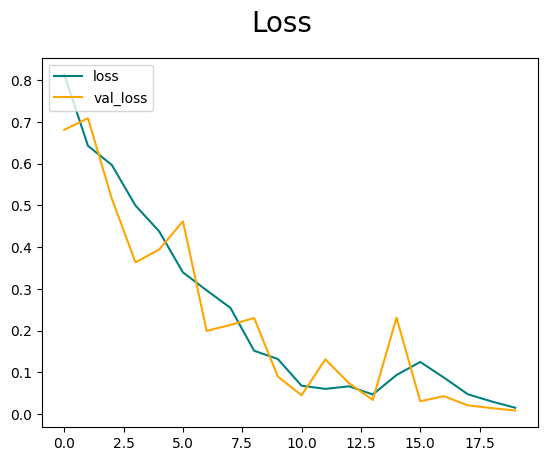

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

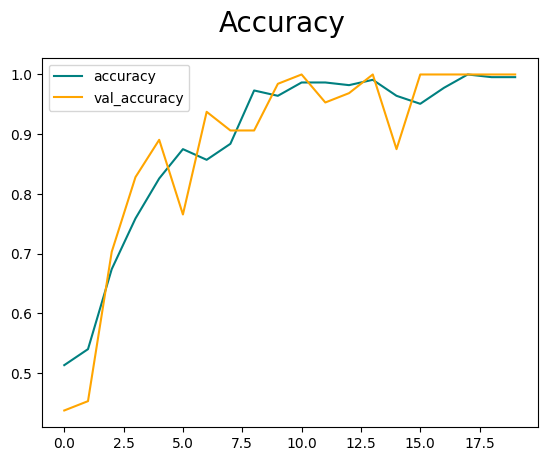

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate model

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 91ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Testing model

In [36]:
import cv2

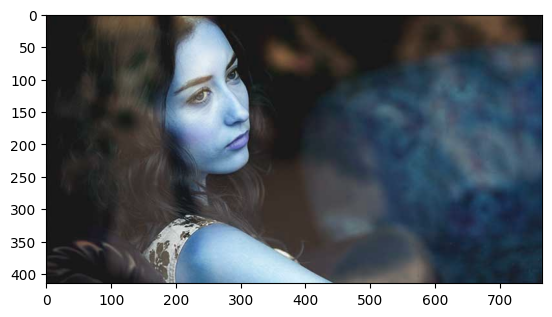

In [37]:
img = cv2.imread('data/sad/766x415_Depression_vs_Sadness.jpg')
plt.imshow(img)
plt.show()

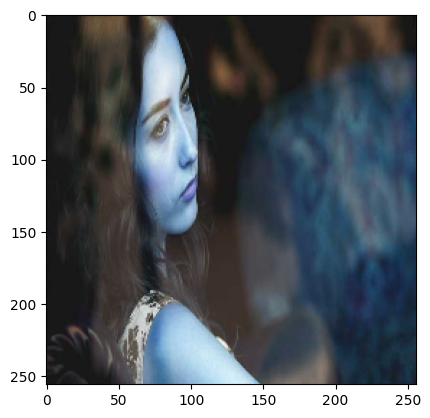

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 14ms/step


In [40]:
yhat

array([[0.9999769]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [47]:
model.save(os.path.join('models','imagemodel.h5'))

In [48]:
new_model = load_model('/Users/remiore/Desktop/ImageClassification/models/imagemodel.h5')

In [49]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 39ms/step


array([[0.9999769]], dtype=float32)